<a href="https://colab.research.google.com/github/PranaliDesai/Deep_Learning/blob/master/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs



fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [23]:
!ls german-traffic-signs 

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd  # for loading csv file 
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)  # unpickling the data
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)    # unpickling the data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)  # unpickling the data
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [26]:
print(X_train.shape) 
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

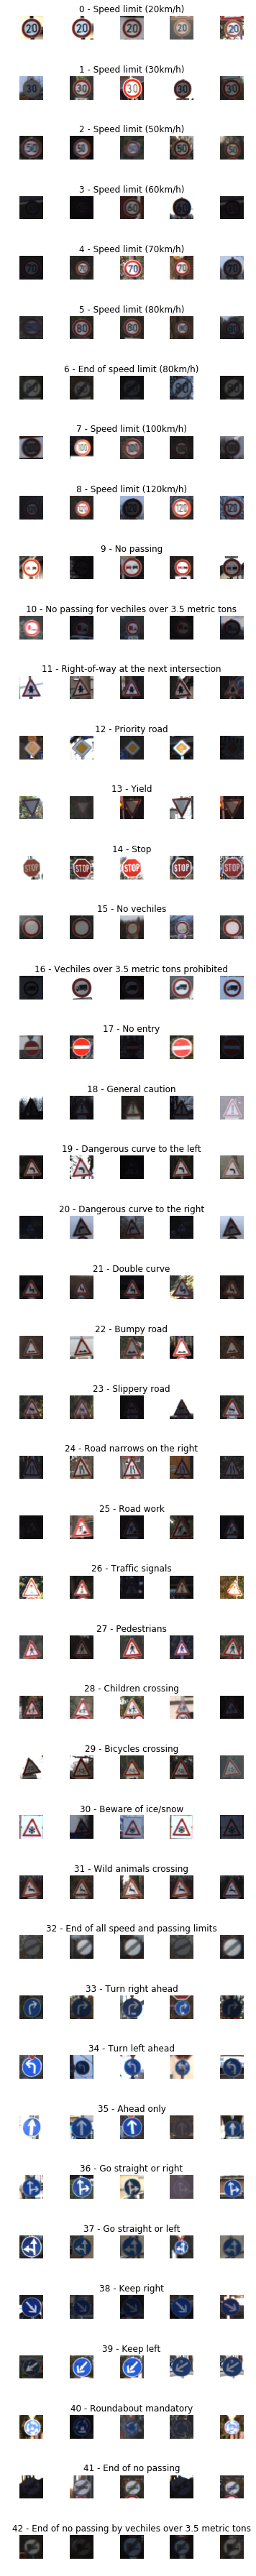

In [28]:
data = pd.read_csv('german-traffic-signs/signnames.csv') # loaded using pandas 
#print(data)
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
  for j, row in data.iterrows(): # iterate over all of over data sets with (index,series)
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


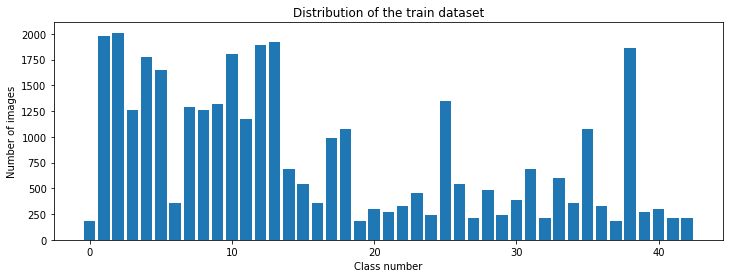

In [29]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
41


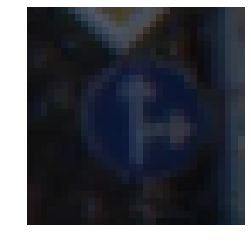

In [30]:
#preprocessing a random image
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[6].shape)
print(y_train[6])

(32, 32)


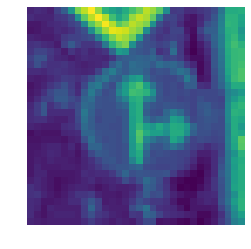

In [31]:
def grayscale(r):
    r = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY) 
    # now the depth will be reduced to 1 so more efficient and less computation 
    return r
img = grayscale(X_train[1000]) # calling the function we defined above 
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


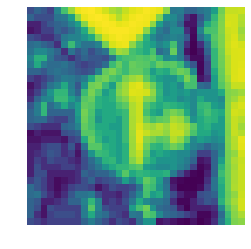

In [32]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
  
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
X_train = np.array(list(map(preprocess, X_train))) # to do so for all the training data 
X_test = np.array(list(map(preprocess, X_test)))   # to do so for all the testing data 
X_val = np.array(list(map(preprocess, X_val)))     # to do so for all the validation data 

(34799, 32, 32)


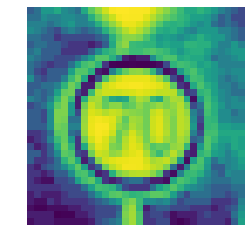

In [34]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1) # reshaping again for perfect input 
X_test = X_test.reshape(12630, 32, 32, 1)# reshaping again for perfect input
X_val = X_val.reshape(4410, 32, 32, 1)# reshaping again for perfect input

(15, 32, 32, 1)


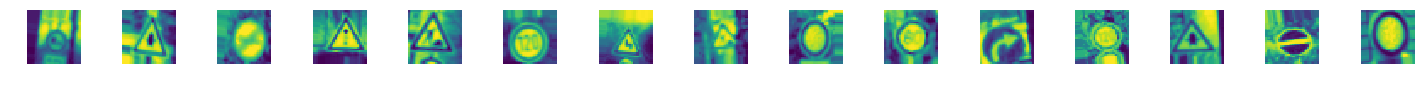

In [36]:
# data augumentation is carried out so that we can extract features and understand varities 
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.) 
#allows us to define types of transformations we wish to make and also allow us to set range 
 
datagen.fit(X_train) 
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15) # requesting
X_batch, y_batch = next(batches) #calls a iterative item 
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [0]:
#one hot encoding 
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43) 

In [0]:
# pooling does not affect depth 
#----reaseon to modify our LeNet model -------#
# a lower learning can help the model when the dataset is complex
# increase number of filter can help our model extract more features (so we double the number of filters)
# we can add more convolution layer to extract features more effectively and increase accuracy
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #model.add(Dropout(0.5)) # one more layer added to remove overfitting 
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(43, activation='softmax'))
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            
  return model

In [39]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
__________

In [40]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),steps_per_epoch=2000,epochs=10, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.9492 - acc: 0.7229 - val_loss: 0.1231 - val_acc: 0.9633
Epoch 2/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.2431 - acc: 0.9235 - val_loss: 0.0603 - val_acc: 0.9798
Epoch 3/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.1654 - acc: 0.9502 - val_loss: 0.0707 - val_acc: 0.9816
Epoch 4/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.1304 - acc: 0.9595 - val_loss: 0.0587 - val_acc: 0.9819
Epoch 5/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1137 - acc: 0.9646 - val_loss: 0.0261 - val_acc: 0.9912
Epoch 6/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.1006 - acc: 0.9694 - val_loss: 0.0298 - val_acc: 0.9900
Epoch 7/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.0903 - acc: 0.9723 - val_loss: 0.0443 - val_acc: 0.9862
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

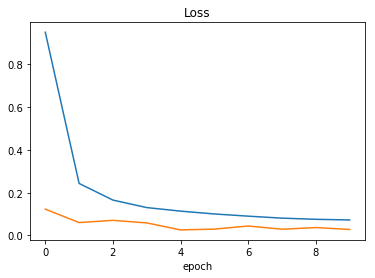

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

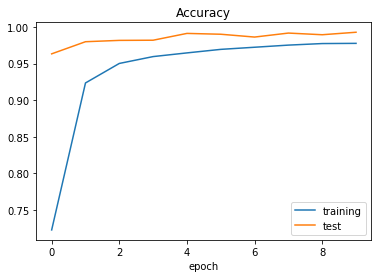

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [50]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12942063190536943
Test accuracy: 0.970467141773242


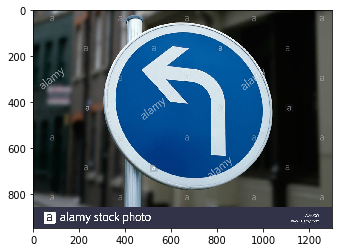

In [51]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


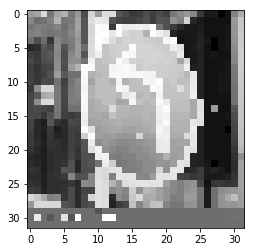

In [52]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)



In [47]:
print("predicted sign: "+ str(model.predict_classes(img)))
 

predicted sign: [34]
